Get all imports

In [1]:
import nibabel as nib
import meshio
import pymeshlab as ml
import plotly as ply
import numpy as np

import os
from os.path import join

from api.registration_utils import segment_high_contrast, display_images, display_images_with_alpha, start_plot, end_plot, plot_values, update_multires_iterations

from skimage.feature import match_descriptors, plot_matches, SIFT

import SimpleITK as sitk
from ipywidgets import interact, fixed
from IPython.display import clear_output

Unable to load the following plugins:

	filter_func.dll: filter_func.dll does not seem to be a Qt Plugin.

Cannot load library C:\Users\Andy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pymeshlab\lib\plugins\filter_func.dll: The specified module could not be found.
	filter_mesh_booleans.dll: filter_mesh_booleans.dll does not seem to be a Qt Plugin.

Cannot load library C:\Users\Andy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pymeshlab\lib\plugins\filter_mesh_booleans.dll: The specified module could not be found.
	filter_sketchfab.dll: filter_sketchfab.dll does not seem to be a Qt Plugin.

Cannot load library C:\Users\Andy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pymeshlab\lib\plugins\filter_sketchfab.dll: The specified module could not be found.
	

Read in image files for reference and target mouse

In this case, the target mouse is the "fixed image"

In [2]:
WORKDIR = os.getcwd()
ATLAS_DIR = join(WORKDIR, "atlas")
DATA_DIR = join(WORKDIR, "data")
ASSETS_DIR = join(WORKDIR, "assets")
REFERENCE_DIR = join(ATLAS_DIR, "reference")

REF_NII = join(REFERENCE_DIR, "mouse_nii", "scaled_atlas.nii")
TARG_NII = join(ASSETS_DIR, "images", "sample", "CT_TS_HEUHR_In111_free_M1039_0h_220721-selfcal.nii")

Read in image files

In [3]:
# ref_mouse = sitk.GetImageFromArray(segment_high_contrast(REF_NII, threshold=.80))
# targ_mouse = sitk.GetImageFromArray(segment_high_contrast(TARG_NII, threshold=.15))
ref_mouse = sitk.GetImageFromArray(nib.load(REF_NII).get_fdata())
targ_mouse = sitk.GetImageFromArray(nib.load(TARG_NII).get_fdata())

interact(display_images, 
         fixed_image_z=(0,targ_mouse.GetSize()[2]-1), 
         moving_image_z=(0,ref_mouse.GetSize()[2]-1), 
         fixed_npa = fixed(sitk.GetArrayViewFromImage(targ_mouse)),
         moving_npa=fixed(sitk.GetArrayViewFromImage(ref_mouse)))

interactive(children=(IntSlider(value=127, description='fixed_image_z', max=255), IntSlider(value=176, descrip…

<function api.registration_utils.display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa)>

Perform initial alignment using `CenteredTransformInitializer`

In [4]:
initial_transform = sitk.CenteredTransformInitializer(targ_mouse,
                                                      ref_mouse,
                                                      sitk.Euler3DTransform(),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

ref_resampled = sitk.Resample(ref_mouse, targ_mouse, initial_transform, sitk.sitkLinear, 0.0, ref_mouse.GetPixelID())

# interact(display_images, 
#          fixed_image_z=(0,targ_mouse.GetSize()[2]-1), 
#          moving_image_z=(0,ref_mouse.GetSize()[2]-1), 
#          fixed_npa = fixed(sitk.GetArrayViewFromImage(targ_mouse)),
#          moving_npa=fixed(sitk.GetArrayViewFromImage(ref_resampled)))
interact(display_images_with_alpha, image_z=(0,targ_mouse.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(targ_mouse), moving=fixed(ref_resampled))

interactive(children=(IntSlider(value=127, description='image_z', max=255), FloatSlider(value=0.5, description…

<function api.registration_utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

Perform registration using 3D rigid transformations

Similarity metric: mutual information (Mattes MI)
- Number of histogram bins: 50
- Sampling strategy: random
- Sampling percentage: 1%

Interpolator: sitkLinear

Optimizer: Gradient Descent
- LR: 1.0
- Num Iterations: 100
- Convergence tolerance: 1e-6
- Convergence window size: 10

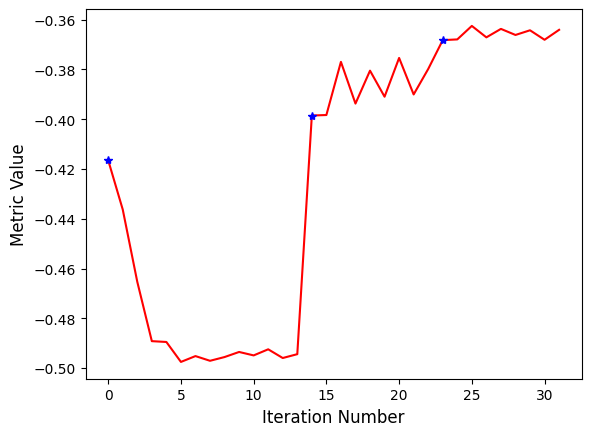

In [5]:
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1.0,
                                                  numberOfIterations=1000,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=10)

registration_method.SetOptimizerScalesFromPhysicalShift()

registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration_method.SetInitialTransform(initial_transform, inPlace=False)
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(targ_mouse, sitk.sitkFloat32), sitk.Cast(ref_mouse, sitk.sitkFloat32))

Analyze registration

In [6]:
print("Optimizer's stopping condition: ", registration_method.GetOptimizerStopConditionDescription())
print("Final metric value: ", registration_method.GetMetricValue())
print(final_transform)

Optimizer's stopping condition:  GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Final metric value:  -0.3676416241247899
itk::simple::CompositeTransform
 CompositeTransform (0000015AE4087CD0)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 858598
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0000015AE3FFB440)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 858444
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.999974 -0.00653484 0.00293844 
       0.00655374 0.999958 -0.00647058 
       -0.00289603 0.00648967 0.999975 
     Offset: [-9.20636, 39.5878, 51.443]
     Center: [285, 127.5, 127.5]
     Translation: [-9.67222, 40.6252, 51.4418]
     Inverse: 
       0.999974 0.00655374 -0.00289603 
       -0.00653484 0.999958 0.00648

In [7]:
ref_registered = sitk.Resample(ref_mouse, 
                              targ_mouse, 
                              final_transform, 
                              sitk.sitkLinear, 
                              0.0, 
                              ref_mouse.GetPixelID())

interact(display_images_with_alpha, image_z=(0,targ_mouse.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(targ_mouse), moving=fixed(ref_registered))

interactive(children=(IntSlider(value=127, description='image_z', max=255), FloatSlider(value=0.5, description…

<function api.registration_utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

Multi scale registration

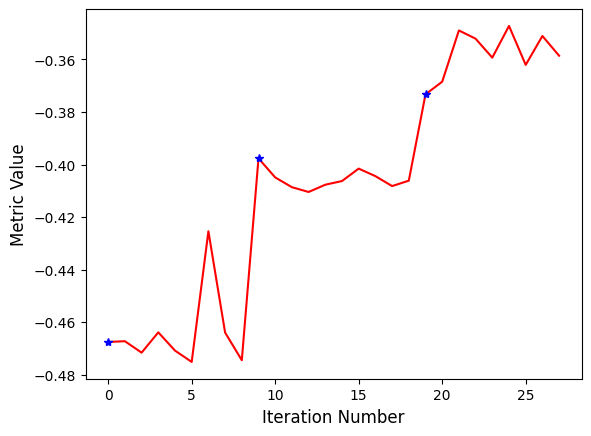

In [8]:
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1.0,
                                                  numberOfIterations=100)
registration_method.SetOptimizerScalesFromPhysicalShift()

scale_transform = sitk.Euler3DTransform(initial_transform)
registration_method.SetInitialTransform(final_transform)

registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_scale_transform = registration_method.Execute(sitk.Cast(targ_mouse, sitk.sitkFloat32), sitk.Cast(ref_mouse, sitk.sitkFloat32))

In [9]:
print(final_scale_transform)

itk::simple::CompositeTransform
 CompositeTransform (0000015AE4087CD0)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 3
   Modified Time: 1714827
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0000015AE3FFB440)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 2
     Modified Time: 1714826
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.999981 -0.00557253 0.00276261 
       0.00554788 0.999945 0.00885116 
       -0.00281178 -0.00883567 0.999957 
     Offset: [-0.591054, 40.458, 53.6834]
     Center: [285, 127.5, 127.5]
     Translation: [-0.954832, 43.1607, 51.7501]
     Inverse: 
       0.999981 0.00554788 -0.00281178 
       -0.00557253 0.999945 -0.00883567 
       0.00276261 0.00885116 0.999957 
     Singular: 0
     Euler's angles: AngleX=-0.00883578 AngleY=0.0028119 AngleZ=0.00557278
     m_Compu

In [10]:
ref_registered = sitk.Resample(ref_mouse, 
                              targ_mouse, 
                              final_scale_transform, 
                              sitk.sitkLinear, 
                              0.0, 
                              ref_mouse.GetPixelID())

interact(display_images_with_alpha, image_z=(0,targ_mouse.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(targ_mouse), moving=fixed(ref_registered))

interactive(children=(IntSlider(value=127, description='image_z', max=255), FloatSlider(value=0.5, description…

<function api.registration_utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

Load segmentation image

In [11]:
atlas = sitk.GetImageFromArray(15 * nib.load("./exports/scaled/scaled_segmentation.nii").get_fdata())
segmentation = sitk.Resample(atlas, targ_mouse, initial_transform, sitk.sitkLinear, 0.0, atlas.GetPixelID())
registered_seg = sitk.Resample(atlas, 
                               targ_mouse,
                               final_scale_transform, 
                               sitk.sitkLinear, 
                               0.0, 
                               atlas.GetPixelID())

interact(display_images_with_alpha, image_z=(0,targ_mouse.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(targ_mouse), moving=fixed(segmentation))
interact(display_images_with_alpha, image_z=(0,targ_mouse.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(targ_mouse), moving=fixed(registered_seg))

interactive(children=(IntSlider(value=127, description='image_z', max=255), FloatSlider(value=0.5, description…

interactive(children=(IntSlider(value=127, description='image_z', max=255), FloatSlider(value=0.5, description…

<function api.registration_utils.display_images_with_alpha(image_z, alpha, fixed, moving)>